In [15]:
from requests_oauthlib import OAuth1Session
import json
import datetime, time, sys
from abc import ABCMeta, abstractmethod
import pandas as pd
from pandas import Series, DataFrame

In [6]:
CK = '4qzQk73Qw5aJfAQ9dcrmWXkdm'                             # Consumer Key
CS = '9o3yAxnEnkXOnFGGMdFTkTCDM6g6FjLt5RqNJAfzEq2KF8U59W'    # Consumer Secret
AT = '115662117-P1nN3CHlh4bQhrWUMtHiz1xt5oYVt9eg8Ra7yzLq'    # Access Token
AS = 'RrRIYr7l2EtyMQ5qMYIMM9FmxFxEK28pxR6pqRVES5oWX'         # Accesss Token Secert

In [7]:
class TweetsGetter(object):
    __metaclass__ = ABCMeta
 
    def __init__(self):
        self.session = OAuth1Session(CK, CS, AT, AS)
 
    @abstractmethod
    def specifyUrlAndParams(self, keyword):
        '''
        呼出し先 URL、パラメータを返す
        '''
 
    @abstractmethod
    def pickupTweet(self, res_text, includeRetweet):
        '''
        res_text からツイートを取り出し、配列にセットして返却
        '''
 
    @abstractmethod
    def getLimitContext(self, res_text):
        '''
        回数制限の情報を取得 （起動時）
        '''
 
    def collect(self, total = -1, onlyText = False, includeRetweet = False):
        '''
        ツイート取得を開始する
        '''
 
        #----------------
        # 回数制限を確認
        #----------------
        self.checkLimit()
 
        #----------------
        # URL、パラメータ
        #----------------
        url, params = self.specifyUrlAndParams()
        params['include_rts'] = str(includeRetweet).lower()
        # include_rts は statuses/user_timeline のパラメータ。search/tweets には無効
 
        #----------------
        # ツイート取得
        #----------------
        cnt = 0
        unavailableCnt = 0
        while True:
            res = self.session.get(url, params = params)
            if res.status_code == 503:
                # 503 : Service Unavailable
                if unavailableCnt > 10:
                    raise Exception('Twitter API error %d' % res.status_code)
 
                unavailableCnt += 1
                print ('Service Unavailable 503')
                self.waitUntilReset(time.mktime(datetime.datetime.now().timetuple()) + 30)
                continue
 
            unavailableCnt = 0
 
            if res.status_code != 200:
                raise Exception('Twitter API error %d' % res.status_code)
 
            tweets = self.pickupTweet(json.loads(res.text))
            if len(tweets) == 0:
                # len(tweets) != params['count'] としたいが
                # count は最大値らしいので判定に使えない。
                # ⇒  "== 0" にする
                # https://dev.twitter.com/discussions/7513
                break
 
            for tweet in tweets:
                if (('retweeted_status' in tweet) and (includeRetweet is False)):
                    pass
                else:
                    if onlyText is True:
                        yield tweet['text']
                    else:
                        yield tweet
 
                    cnt += 1
                    if cnt % 100 == 0:
                        print ('%d件 ' % cnt)
 
                    if total > 0 and cnt >= total:
                        return
 
            params['max_id'] = tweet['id'] - 1
 
            # ヘッダ確認 （回数制限）
            # X-Rate-Limit-Remaining が入ってないことが稀にあるのでチェック
            if ('X-Rate-Limit-Remaining' in res.headers and 'X-Rate-Limit-Reset' in res.headers):
                if (int(res.headers['X-Rate-Limit-Remaining']) == 0):
                    self.waitUntilReset(int(res.headers['X-Rate-Limit-Reset']))
                    self.checkLimit()
            else:
                print ('not found  -  X-Rate-Limit-Remaining or X-Rate-Limit-Reset')
                self.checkLimit()
 
    def checkLimit(self):
        '''
        回数制限を問合せ、アクセス可能になるまで wait する
        '''
        unavailableCnt = 0
        while True:
            url = "https://api.twitter.com/1.1/application/rate_limit_status.json"
            res = self.session.get(url)
 
            if res.status_code == 503:
                # 503 : Service Unavailable
                if unavailableCnt > 10:
                    raise Exception('Twitter API error %d' % res.status_code)
 
                unavailableCnt += 1
                print ('Service Unavailable 503')
                self.waitUntilReset(time.mktime(datetime.datetime.now().timetuple()) + 30)
                continue
 
            unavailableCnt = 0
 
            if res.status_code != 200:
                raise Exception('Twitter API error %d' % res.status_code)
 
            remaining, reset = self.getLimitContext(json.loads(res.text))
            if (remaining == 0):
                self.waitUntilReset(reset)
            else:
                break
 
    def waitUntilReset(self, reset):
        '''
        reset 時刻まで sleep
        '''
        seconds = reset - time.mktime(datetime.datetime.now().timetuple())
        seconds = max(seconds, 0)
        print ('\n     =====================')
        print ('     == waiting %d sec ==' % seconds)
        print ('     =====================')
        sys.stdout.flush()
        time.sleep(seconds + 10)  # 念のため + 10 秒
 
    @staticmethod
    def bySearch(keyword):
        return TweetsGetterBySearch(keyword)
 
    @staticmethod
    def byUser(screen_name):
        return TweetsGetterByUser(screen_name)
 

In [8]:
class TweetsGetterBySearch(TweetsGetter):
    '''
    キーワードでツイートを検索
    '''
    def __init__(self, keyword):
        super(TweetsGetterBySearch, self).__init__()
        self.keyword = keyword
        
    def specifyUrlAndParams(self):
        '''
        呼出し先 URL、パラメータを返す
        '''
        url = 'https://api.twitter.com/1.1/search/tweets.json'
        params = {'q':self.keyword, 'count':100}
        return url, params
 
    def pickupTweet(self, res_text):
        '''
        res_text からツイートを取り出し、配列にセットして返却
        '''
        results = []
        for tweet in res_text['statuses']:
            results.append(tweet)
 
        return results
 
    def getLimitContext(self, res_text):
        '''
        回数制限の情報を取得 （起動時）
        '''
        remaining = res_text['resources']['search']['/search/tweets']['remaining']
        reset     = res_text['resources']['search']['/search/tweets']['reset']
 
        return int(remaining), int(reset)

In [9]:
created_at = []
text = []

# キーワードで取得
getter = TweetsGetter.bySearch('八幡浜 AND -filter:retweets AND -filter:replies')

# ユーザーを指定して取得 （screen_name）
#getter = TweetsGetter.byUser('AbeShinzo')

cnt = 0
for tweet in getter.collect(total = 1000000):
    #cnt += 1
    #print ('------ %d' % cnt)
    #print ('{} {} {}'.format(tweet['id'], tweet['created_at'], '@'+tweet['user']['screen_name']))
    #print (tweet['text'])
    created_at.append(tweet['created_at'])
    text.append(tweet['text'])

100件 
200件 
300件 
400件 
500件 
600件 


In [53]:
created_at = Series(created_at)
text = Series(text)

#各シリーズをデータフレーム化
YH_df = pd.concat([created_at, text],axis=1)

#カラム名
YH_df.columns=['created_at','text']

#csvファイルとして保存
YH_df.to_csv('Yawatahama_25042018.csv', sep = '\t',encoding='utf-16')

In [54]:
YH_df.head()

,created_at,text
0,Wed Apr 25 12:42:12 +0000 2018,夕陽にカンパイしながらのエロ話が楽しい、愛媛・八幡浜の宿 https://t.co/Wih4...
1,Wed Apr 25 12:27:41 +0000 2018,玉ねぎの収穫が始まりだしました。\nまずは極早生から。\n#新玉ねぎ #玉ねぎ #極早生 #...
2,Wed Apr 25 12:09:17 +0000 2018,夕陽にカンパイしながらのエロ話が楽しい、愛媛・八幡浜の宿 https://t.co/had3...
3,Wed Apr 25 12:07:43 +0000 2018,大洗も苫小牧も小樽も東舞鶴も東予も松山も別府も西大分も神戸も大阪も徳島も高松も宇野も呉も広島...
4,Wed Apr 25 11:52:27 +0000 2018,名坂おかげ地蔵で春の縁日: 八幡浜市大平の「名坂おかげ地蔵」で24日、春の縁日祭が催され、法...


In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [66]:
from dateutil import parser
YH_df["date"] = YH_df["created_at"].apply(parser.parse)
YH_df["date"] = pd.to_datetime(YH_df["date"])

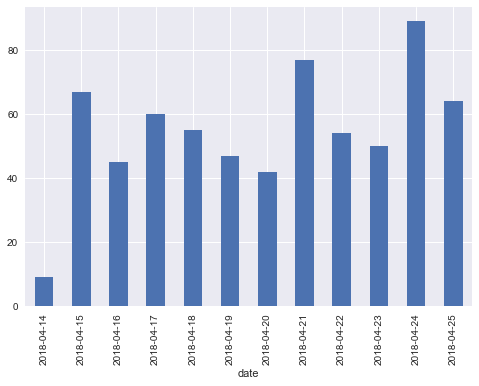

In [67]:
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")
#sns.distplot(YH_df["date"])
